# Learning Best Practices for Model Evaluation and Hyperparameter Tuning

In [1]:
import pandas as pd
df = pd.read_csv('https://archive.ics.uci.edu/ml/machine-learning-databases/breast-cancer-wisconsin/wdbc.data',
                 header=None)

In [2]:
from sklearn.preprocessing import LabelEncoder
X = df.iloc[:, 2:].values
y = df.iloc[:, 1].values
le = LabelEncoder()
y = le.fit_transform(y)
X.shape

(569, 30)

In [3]:
le.classes_

array(['B', 'M'], dtype=object)

In [4]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=1)

In [5]:
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline
pipe_lr = Pipeline([('scl', StandardScaler()),
                    ('pca', PCA(n_components=2)),
                    ('clf', LogisticRegression(random_state=1))])
pipe_lr.fit(X_train, y_train)
print('Test Accuracy: %.3f' % pipe_lr.score(X_test, y_test))

Test Accuracy: 0.947


In [6]:
import numpy as np
from sklearn.model_selection import StratifiedKFold
kfold = StratifiedKFold(n_splits=10, random_state=1)
scores = []

for k, (train, test) in enumerate(kfold.split(X=X_train, y=y_train)):
    pipe_lr.fit(X_train[train], y_train[train])
    score = pipe_lr.score(X_train[test], y_train[test])
    scores.append(score)
    print('Fold: %s, Class dist.: %s, Acc: %.3f' % (k+1, np.bincount(y_train[train]), score))

Fold: 1, Class dist.: [256 153], Acc: 0.891
Fold: 2, Class dist.: [256 153], Acc: 0.978
Fold: 3, Class dist.: [256 153], Acc: 0.978
Fold: 4, Class dist.: [256 153], Acc: 0.913
Fold: 5, Class dist.: [256 153], Acc: 0.935
Fold: 6, Class dist.: [257 153], Acc: 0.978
Fold: 7, Class dist.: [257 153], Acc: 0.933
Fold: 8, Class dist.: [257 153], Acc: 0.956
Fold: 9, Class dist.: [257 153], Acc: 0.978
Fold: 10, Class dist.: [257 153], Acc: 0.956


In [7]:
print('CV accuracy: %.3f +/- %.3f' % (np.mean(scores), np.std(scores)))

CV accuracy: 0.950 +/- 0.029


In [8]:
from sklearn.model_selection import cross_val_score
scores = cross_val_score(pipe_lr, X_train, y=y_train, cv=10, n_jobs=1)
print('CV accuracy: %s' % scores)

CV accuracy: [ 0.89130435  0.97826087  0.97826087  0.91304348  0.93478261  0.97777778
  0.93333333  0.95555556  0.97777778  0.95555556]


In [9]:
print('CV accuracy: %.3f +/- %.3f' % (np.mean(scores), np.std(scores)))

CV accuracy: 0.950 +/- 0.029


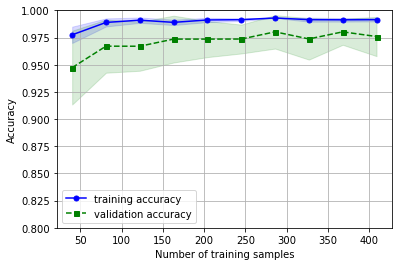

In [10]:
import matplotlib.pyplot as plt
from sklearn.model_selection import learning_curve
pipe_lr = Pipeline([('scl', StandardScaler()),
                    ('clf', LogisticRegression(penalty='l2', random_state=0))])
train_sizes, train_scores, test_scores = learning_curve(estimator=pipe_lr,
                                                        X=X_train,
                                                        y=y_train,
                                                        train_sizes=np.linspace(0.1, 1.0, 10),
                                                        cv=10,
                                                        n_jobs=1)
train_mean = np.mean(train_scores, axis=1)
train_std = np.std(train_scores, axis=1)
test_mean = np.mean(test_scores, axis=1)
test_std = np.std(test_scores, axis=1)

plt.plot(train_sizes, train_mean, color='blue', marker='o', markersize=5, label='training accuracy')
plt.fill_between(train_sizes, train_mean+train_std, train_mean-train_std, alpha=0.15, color='blue')

plt.plot(train_sizes, test_mean, color='green', marker='s', markersize=5, linestyle='--', label='validation accuracy')
plt.fill_between(train_sizes, test_mean+test_std, test_mean-test_std, alpha=0.15, color='green')

plt.grid()
plt.xlabel('Number of training samples')
plt.ylabel('Accuracy')
plt.legend(loc='best')
plt.ylim([0.8, 1.0])
plt.show()

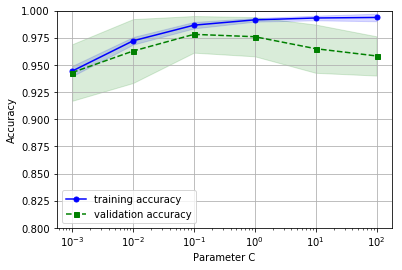

In [11]:
from sklearn.model_selection import validation_curve
param_range = [0.001, 0.01, 0.1, 1.0, 10.0, 100.0]
train_scores, test_scores = validation_curve(
    estimator=pipe_lr,
    X=X_train,
    y=y_train,
    param_name='clf__C', param_range=param_range, cv=10)
train_mean = np.mean(train_scores, axis=1)
train_std = np.std(train_scores, axis=1)
test_mean = np.mean(test_scores, axis=1)
test_std = np.std(test_scores, axis=1)

plt.plot(param_range, train_mean, color='blue', marker='o', markersize=5, label='training accuracy')
plt.fill_between(param_range, train_mean+train_std, train_mean-train_std, alpha=0.15, color='blue')

plt.plot(param_range, test_mean, color='green', marker='s', markersize=5, linestyle='--', label='validation accuracy')
plt.fill_between(param_range, test_mean+test_std, test_mean-test_std, alpha=0.15, color='green')

plt.grid()
plt.xscale('log')
plt.xlabel('Parameter C')
plt.ylabel('Accuracy')
plt.legend(loc='best')
plt.ylim([0.8, 1.0])
plt.show()

In [12]:
from sklearn.model_selection import GridSearchCV
from sklearn.svm import SVC
pipe_svc = Pipeline([('scl', StandardScaler()),
                     ('clf', SVC(random_state=1))])
param_range = [10**k for k in range(-4, 4)]
param_grid = [{'clf__C': param_range,
               'clf__kernel': ['linear']},
              {'clf__C': param_range,
               'clf__gamma': param_range,
               'clf__kernel': ['rbf']}]
gs = GridSearchCV(estimator=pipe_svc,
                  param_grid=param_grid,
                  scoring='accuracy',
                  cv=10,
                  n_jobs=-1)
gs = gs.fit(X_train, y_train)
print(gs.best_score_)
print(gs.best_params_)

0.978021978022
{'clf__C': 0.1, 'clf__kernel': 'linear'}


In [13]:
clf = gs.best_estimator_
clf.fit(X_train, y_train)
print('Test accuracy: %.3f' % clf.score(X_test, y_test))

Test accuracy: 0.965


In [14]:
gs = GridSearchCV(estimator=pipe_svc,
                  param_grid=param_grid,
                  scoring='accuracy',
                  cv=2,
                  n_jobs=-1)
scores = cross_val_score(gs, X_train, y_train, scoring='accuracy', cv=5)
print('CV accuracy: %.3f +/- %.3f' % (np.mean(scores), np.std(scores)))

CV accuracy: 0.965 +/- 0.025


In [15]:
from sklearn.tree import DecisionTreeClassifier
gs = GridSearchCV(estimator=DecisionTreeClassifier(random_state=0),
                  param_grid=[{'max_depth': [1, 2, 3, 4, 5, 6, 7, None]}],
                  scoring='accuracy',
                  cv=2)
scores = cross_val_score(gs, 
                         X_train,
                         y_train,
                         scoring='accuracy',
                         cv=5)
print('CV accuracy: %.3f +/- %.3f' % (np.mean(scores), np.std(scores)))

CV accuracy: 0.921 +/- 0.029


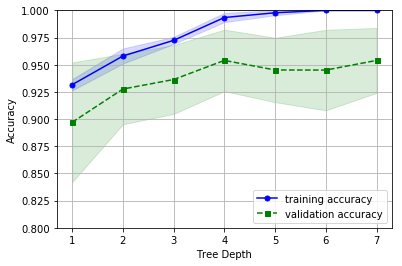

In [16]:
from sklearn.model_selection import validation_curve
param_range = [1, 2, 3, 4, 5, 6, 7]
train_scores, test_scores = validation_curve(
    estimator=DecisionTreeClassifier(random_state=None),
    X=X_train,
    y=y_train,
    param_name='max_depth', param_range=param_range, cv=10)
train_mean = np.mean(train_scores, axis=1)
train_std = np.std(train_scores, axis=1)
test_mean = np.mean(test_scores, axis=1)
test_std = np.std(test_scores, axis=1)

plt.plot(param_range, train_mean, color='blue', marker='o', markersize=5, label='training accuracy')
plt.fill_between(param_range, train_mean+train_std, train_mean-train_std, alpha=0.15, color='blue')

plt.plot(param_range, test_mean, color='green', marker='s', markersize=5, linestyle='--', label='validation accuracy')
plt.fill_between(param_range, test_mean+test_std, test_mean-test_std, alpha=0.15, color='green')

plt.grid()
plt.xlabel('Tree Depth')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')
plt.ylim([0.8, 1.0])
plt.show()

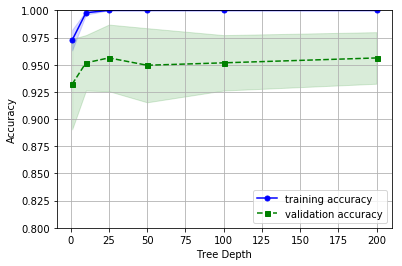

In [17]:
from sklearn.model_selection import validation_curve
from sklearn.ensemble import RandomForestClassifier

param_range = [1, 10, 25, 50, 100, 200]
train_scores, test_scores = validation_curve(
    estimator=RandomForestClassifier(random_state=None),
    X=X_train,
    y=y_train,
    param_name='n_estimators', param_range=param_range, cv=10)
train_mean = np.mean(train_scores, axis=1)
train_std = np.std(train_scores, axis=1)
test_mean = np.mean(test_scores, axis=1)
test_std = np.std(test_scores, axis=1)

plt.plot(param_range, train_mean, color='blue', marker='o', markersize=5, label='training accuracy')
plt.fill_between(param_range, train_mean+train_std, train_mean-train_std, alpha=0.15, color='blue')

plt.plot(param_range, test_mean, color='green', marker='s', markersize=5, linestyle='--', label='validation accuracy')
plt.fill_between(param_range, test_mean+test_std, test_mean-test_std, alpha=0.15, color='green')

plt.grid()
plt.xlabel('Tree Depth')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')
plt.ylim([0.8, 1.0])
plt.show()

0.96043956044
{'max_depth': 7, 'n_estimators': 50}


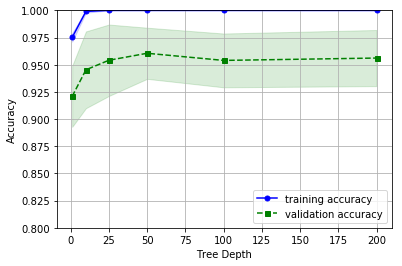

In [18]:
from sklearn.model_selection import GridSearchCV

param_grid = [{'max_depth': [1,2,3,4,5,6,7,8,9,None],
               'n_estimators': [1, 10, 25, 50, 100, 200]}]
gs = GridSearchCV(estimator=RandomForestClassifier(random_state=1),
                  param_grid=param_grid,
                  scoring='accuracy',
                  cv=10,
                  n_jobs=-1)
gs = gs.fit(X_train, y_train)
print(gs.best_score_)
print(gs.best_params_)

train_scores, test_scores = validation_curve(
    estimator=gs.best_estimator_,
    X=X_train,
    y=y_train,
    param_name='n_estimators', param_range=[1, 10, 25, 50, 100, 200], cv=10)
train_mean = np.mean(train_scores, axis=1)
train_std = np.std(train_scores, axis=1)
test_mean = np.mean(test_scores, axis=1)
test_std = np.std(test_scores, axis=1)

plt.plot(param_range, train_mean, color='blue', marker='o', markersize=5, label='training accuracy')
plt.fill_between(param_range, train_mean+train_std, train_mean-train_std, alpha=0.15, color='blue')

plt.plot(param_range, test_mean, color='green', marker='s', markersize=5, linestyle='--', label='validation accuracy')
plt.fill_between(param_range, test_mean+test_std, test_mean-test_std, alpha=0.15, color='green')

plt.grid()
plt.xlabel('Tree Depth')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')
plt.ylim([0.8, 1.0])
plt.show()

In [19]:
from sklearn.model_selection import cross_val_score

cross_val_score(estimator=RandomForestClassifier(random_state=1, n_estimators=1, max_depth=10),
                X=X_train,
                y=y_train,
                scoring='accuracy',
                cv=10)

array([ 0.95652174,  0.91304348,  0.95652174,  0.86956522,  0.91304348,
        0.95555556,  0.93333333,  0.88888889,  0.91111111,  0.91111111])

In [20]:
n_ests = [1, 10, 25, 50, 100, 200]
m_depths = [1,2,3,4,5,6,7,8,9,None]

acc_mat = np.array([[np.mean(cross_val_score(estimator=RandomForestClassifier(random_state=1, 
                                                                              n_estimators=n_est, 
                                                                              max_depth=m_depth),
                          X=X_train,
                          y=y_train,
                          scoring='accuracy',
                          cv=10,
                          n_jobs=-1)) for n_est in n_ests] for m_depth in m_depths])

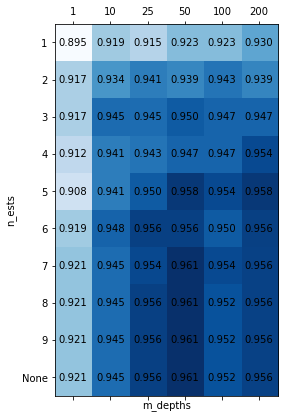

In [21]:
plt.matshow(acc_mat, cmap=plt.cm.Blues, alpha=1)
for i in range(acc_mat.shape[0]):
    for j in range(acc_mat.shape[1]):
        plt.text(x=j,
                 y=i,
                 s='%.3f' % acc_mat[i, j],
                 va='center', ha='center')
plt.ylabel('n_ests')
plt.xlabel('m_depths')
plt.xticks(range(len(n_ests)), n_ests)
plt.yticks(range(len(m_depths)), m_depths)
plt.show()

In [22]:
from sklearn.metrics import confusion_matrix
pipe_svc.fit(X_train, y_train)
y_pred = pipe_svc.predict(X_test)
confmat = confusion_matrix(y_true=y_test, y_pred=y_pred)
print(confmat)

[[71  1]
 [ 2 40]]


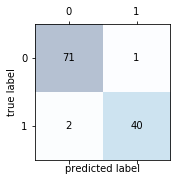

In [23]:
fig, ax = plt.subplots(figsize=(2.5, 2.5))
ax.matshow(confmat, cmap=plt.cm.Blues, alpha=0.3)
for i in range(confmat.shape[0]):
    for j in range(confmat.shape[1]):
        ax.text(x=j, y=i,
                s=confmat[i,j],
                va='center', ha='center')
plt.xlabel('predicted label')
plt.ylabel('true label')
plt.show()

In [24]:
ACC = (confmat[0,0]+confmat[1,1])/confmat.sum()
ERR = 1-ACC
FPR = confmat[0,1] / confmat[0,:].sum()
TPR = confmat[1,1] / confmat[1,:].sum()
PRE = confmat[1,1] / confmat[:,1].sum()
REC = TPR
F1 = 2*(PRE*REC)/(PRE+REC)

print('Accuracy: %.3f\n'
      'Error: %.3f\n'
      'False Positive Rate: %.3f\n'
      'True Positive Rate: %.3f\n'
      'Precision: %.3f\n'
      'Recall: %.3f\n'
      'F1-score: %.3f'
      % (ACC, ERR, FPR, TPR, PRE, REC, F1))

Accuracy: 0.974
Error: 0.026
False Positive Rate: 0.014
True Positive Rate: 0.952
Precision: 0.976
Recall: 0.952
F1-score: 0.964


In [25]:
from sklearn.metrics import precision_score, recall_score, f1_score
print('Precision: %.3f\n'
      'Recall: %.3f\n'
      'F1-score: %.3f' % (precision_score(y_true=y_test, y_pred=y_pred),
                          recall_score(y_true=y_test, y_pred=y_pred),
                          f1_score(y_true=y_test, y_pred=y_pred)))

Precision: 0.976
Recall: 0.952
F1-score: 0.964


In [26]:
from sklearn.metrics import make_scorer, f1_score
scorer = make_scorer(f1_score, pos_label=0)

param_range = [10**k for k in range(-4, 4)]
param_grid = [{'clf__C': param_range,
               'clf__kernel': ['linear']},
              {'clf__C': param_range,
               'clf__gamma': param_range,
               'clf__kernel': ['rbf']}]

gs = GridSearchCV(estimator=pipe_svc,
                  param_grid=param_grid,
                  scoring=scorer,
                  cv=10)
gs.fit(X_train, y_train)
gs.best_params_

{'clf__C': 0.1, 'clf__kernel': 'linear'}

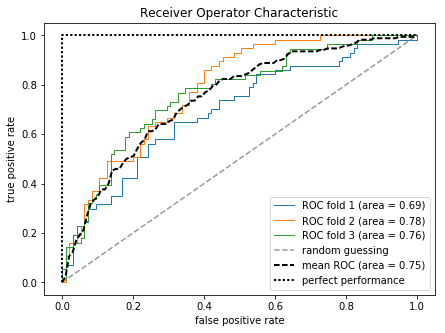

In [27]:
from sklearn.metrics import roc_curve, auc
from scipy import interp

pipe_lr = Pipeline([('scl', StandardScaler()),
                    ('pca', PCA(n_components=2)),
                    ('clf', LogisticRegression(penalty='l2', random_state=0, C=100.0))])

X_train2 = X_train[:, [4, 14]]
cv = StratifiedKFold(n_splits=3, random_state=1)

fig = plt.figure(figsize=(7, 5))
mean_tpr = 0.0
mean_fpr = np.linspace(0, 1, 100)
all_tpr = []

for i, (train, test) in enumerate(cv.split(X=X_train, y=y_train)):
    probas = pipe_lr.fit(X_train2[train], y_train[train]).predict_proba(X_train2[test])
    fpr, tpr, thresholds = roc_curve(y_train[test], probas[:, 1], pos_label=1)
    mean_tpr += interp(mean_fpr, fpr, tpr)
    mean_tpr[0] = 0.0
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, lw=1, label='ROC fold %d (area = %.2f)' % (i+1, roc_auc))

plt.plot([0, 1], [0, 1], linestyle='--', color=(0.6, 0.6, 0.6), label = 'random guessing')

mean_tpr /= cv.get_n_splits()
mean_tpr[-1] = 1.0
mean_auc = auc(mean_fpr, mean_tpr)
plt.plot(mean_fpr, mean_tpr, 'k--', label='mean ROC (area = %0.2f)' % mean_auc, lw=2)

plt.plot([0, 0, 1], [0, 1, 1], lw=2, linestyle=':', color='black', label='perfect performance')
plt.xlim([-0.05, 1.05])
plt.ylim([-0.05, 1.05])
plt.xlabel('false positive rate')
plt.ylabel('true positive rate')
plt.title('Receiver Operator Characteristic')
plt.legend(loc="lower right")
plt.show()

In [28]:
pipe_lr = pipe_lr.fit(X_train2, y_train)
y_pred2 = pipe_lr.predict(X_test[:, [4, 14]])

from sklearn.metrics import roc_auc_score
from sklearn.metrics import accuracy_score
print('ROC AUC: %.3f' % roc_auc_score(y_true=y_test, y_score=y_pred2))
print('Accuracy: %.3f' % accuracy_score(y_true=y_test, y_pred=y_pred2))

ROC AUC: 0.662
Accuracy: 0.711


In [29]:
pre_scorer = make_scorer(score_func=precision_score,
                         pos_label=1,
                         greater_is_better=True,
                         average='micro')

In [30]:
# Moje wypociny #

In [31]:
import pandas as pd
df_wine = pd.read_csv('https://archive.ics.uci.edu/ml/'
                      'machine-learning-databases/wine/wine.data',
                      header=None)
df_wine.columns = ['Class label', 'Alcohol',
                   'Malic acid', 'Ash',
                   'Alcalinity of ash', 'Magnesium',
                   'Total phenols', 'Flavanoids',
                   'Nonflavanoid phenols',
                   'Proanthocyanins',
                   'Color intensity', 'Hue',
                   'OD280/OD315 of diluted wines',
                   'Proline']
print('Class labels', np.unique(df_wine['Class label']))
df_wine.head()

Class labels [1 2 3]


,Class label,Alcohol,Malic acid,Ash,Alcalinity of ash,Magnesium,Total phenols,Flavanoids,Nonflavanoid phenols,Proanthocyanins,Color intensity,Hue,OD280/OD315 of diluted wines,Proline
0,1,14.23,1.71,2.43,15.6,127,2.80,3.06,0.28,2.29,5.64,1.04,3.92,1065
1,1,13.20,1.78,2.14,11.2,100,2.65,2.76,0.26,1.28,4.38,1.05,3.40,1050
2,1,13.16,2.36,2.67,18.6,101,2.80,3.24,0.30,2.81,5.68,1.03,3.17,1185
3,1,14.37,1.95,2.50,16.8,113,3.85,3.49,0.24,2.18,7.80,0.86,3.45,1480
4,1,13.24,2.59,2.87,21.0,118,2.80,2.69,0.39,1.82,4.32,1.04,2.93,735


In [32]:
Y_total = df_wine.iloc[:, 0]
X_total = df_wine.iloc[:, 1:]
Y_total.shape, X_total.shape

((178,), (178, 13))

In [33]:
from sklearn.model_selection import train_test_split

In [34]:
Y_train, Y_test, X_train, X_test = train_test_split(Y_total, X_total, test_size = 0.3, random_state = 123, stratify=Y_total)

In [35]:
Y_train.shape, Y_test.shape, X_train.shape, X_test.shape

((124,), (54,), (124, 13), (54, 13))

In [36]:
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

random_state = 123

pipe = Pipeline([('scaler', StandardScaler()),
                 ('pca', PCA(n_components=3, random_state=random_state)),
                 ('logistic', LogisticRegression(penalty='l2', C=1.0, random_state=123))])

In [37]:
pipe.fit(X_train, Y_train)
pred = pipe.predict(X_test)

In [38]:
from sklearn.metrics import accuracy_score, precision_score, confusion_matrix, f1_score
print('accuracy %.3f' % accuracy_score(Y_test, pred))
print('precision %.3f' % precision_score(Y_test, pred, average='weighted'))
print('f1-score %.3f' % f1_score(Y_test, pred, average='weighted'))

accuracy 0.963
precision 0.963
f1-score 0.963


In [39]:
confusion_matrix(Y_test, pred)

array([[17,  1,  0],
       [ 1, 20,  0],
       [ 0,  0, 15]])

In [40]:
from sklearn.model_selection import ParameterGrid
param_grid = [{'pca__n_components': range(1, 10),
               'logistic__penalty': ['l1', 'l2'],
               'logistic__C': [10**k for k in range(-3, 4)]}]

In [41]:
from sklearn.model_selection import GridSearchCV

In [42]:
scorer = make_scorer(score_func=accuracy_score)
result = GridSearchCV(estimator=pipe, param_grid=param_grid, scoring=scorer, n_jobs=2, cv=10)

In [43]:
result = result.fit(X_train, Y_train)

In [44]:
print(result.best_params_)
print(result.best_estimator_)
print(result.best_score_)

{'logistic__C': 1, 'logistic__penalty': 'l2', 'pca__n_components': 6}
Pipeline(steps=[('scaler', StandardScaler(copy=True, with_mean=True, with_std=True)), ('pca', PCA(copy=True, iterated_power='auto', n_components=6, random_state=123,
  svd_solver='auto', tol=0.0, whiten=False)), ('logistic', LogisticRegression(C=1, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=123, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False))])
0.983870967742


In [45]:
pred = result.best_estimator_.predict(X_test)

In [46]:
print('accuracy %.3f' % accuracy_score(Y_test, pred))
print('precision %.3f' % precision_score(Y_test, pred, average='weighted'))
print('f1-score %.3f' % f1_score(Y_test, pred, average='weighted'))

accuracy 0.981
precision 0.982
f1-score 0.982


In [47]:
gs = GridSearchCV(estimator=pipe,
                  param_grid=param_grid,
                  scoring=scorer,
                  cv=4)
scores = cross_val_score(gs, 
                         X_train,
                         Y_train,
                         scoring=scorer,
                         cv=5)
print('CV accuracy: %.3f +/- %.3f' % (np.mean(scores), np.std(scores)))
print(scores)

CV accuracy: 0.976 +/- 0.020
[ 0.96153846  1.          1.          0.95833333  0.95833333]
